# Streaming data visualisation

In [195]:
# import statements
from time import sleep
from kafka3 import KafkaConsumer
from datetime import datetime
import matplotlib.pyplot as plt
import json

%matplotlib notebook

In [196]:
ip_address = "192.168.224.1" # Change to host
topic = "climate_topic"

<IPython.core.display.Javascript object>


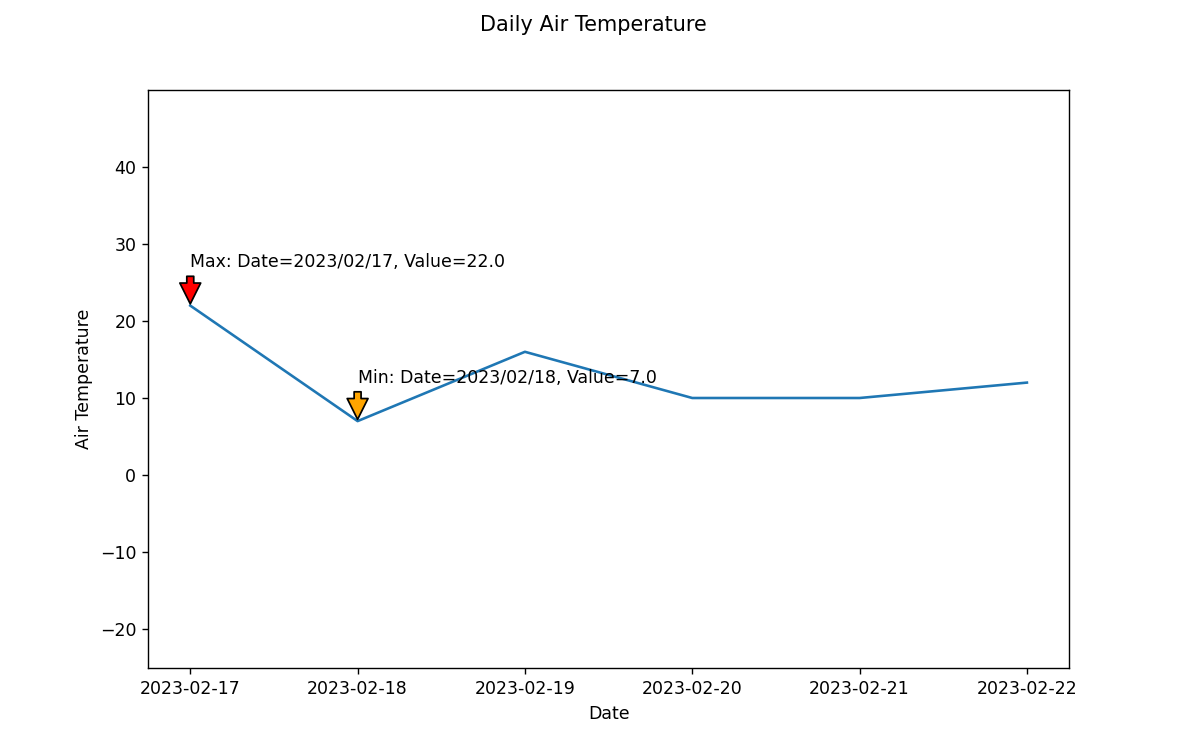

KeyboardInterrupt: 

In [197]:
# Annotate the maximum value
def annotate_max(x, y, ax = None):
    ymax = max(y)
    xpos = y.index(ymax)
    xmax = x[xpos]
    xmax_str = datetime.strftime(xmax, "%Y/%m/%d") # Get date format in year/month/day
    text = 'Max: Date={}, Value={}'.format(xmax_str, ymax)
    if not ax:
        ax=plt.gca()
    ax.annotate(text, xy=(xmax, ymax), xytext=(xmax, ymax+5), arrowprops=dict(facecolor='red', shrink=0.05),)

# Annotate the minimum value
def annotate_min(x, y, ax = None):
    ymin = min(y)
    xpos = y.index(ymin)
    xmin = x[xpos]
    xmin_str = datetime.strftime(xmin, "%Y/%m/%d") # Get date format in year/month/day
    text = 'Min: Date={}, Value={}'.format(xmin_str, ymin)
    if not ax:
        ax=plt.gca() # Get current axis
    ax.annotate(text, xy=(xmin, ymin), xytext=(xmin, ymin+5), arrowprops=dict(facecolor='orange', shrink=0.05),)

def connect_kafka_consumer():
    _consumer = None
    try:
         _consumer = KafkaConsumer(topic,
                                   consumer_timeout_ms=30000, # stop iteration if no message after 30 sec
#                                    auto_offset_reset='earliest', # comment this if you don't want to consume earliest available message
                                   bootstrap_servers=[f'{ip_address}:9092'],
                                   api_version=(0, 10))
    except Exception as ex:
        print('Exception while connecting Kafka')
        print(str(ex))
    finally:
        return _consumer

def init_plots():
    try:
        width = 9.5
        height = 6
        fig = plt.figure(figsize=(width,height)) # create new figure
        ax = fig.add_subplot(111) # adding the subplot axes to the given grid position
        fig.suptitle('Daily Air Temperature') # giving figure a title
        ax.set_xlabel('Date')
        ax.set_ylabel('Air Temperature')
        ax.set_ylim(-25,50) # Account for negative temperature and high temperature
        ax.set_yticks([-20, -10, 0, 10, 20, 30, 40])
        fig.show() # displaying the figure
        fig.canvas.draw() # drawing on the canvas
        return fig, ax
    except Exception as ex:
        print(str(ex))
    
def consume_messages(consumer, fig, ax):
    try:
        # container for x and y values
        x, y = [], []
        # print('Waiting for messages')
        for message in consumer:
            # Load json data
            data = json.loads(message.value)
            # Append date to x
            date = data["date"]
            date = datetime.strptime(date, "%Y/%m/%d")
            x.append(date) 
            # Append air temperature to y
            air_temperature = data["air_temperature"]
            y.append(float(air_temperature))
            # print(y)
            # start plotting after we have 2 data point
            if len(y) > 1:
                ax.clear()
                ax.plot(x, y)
                ax.set_xlabel('Date')
                ax.set_ylabel('Air Temperature')
                ax.set_ylim(-25,50)
                ax.set_yticks([-20, -10, 0, 10, 20, 30, 40])
                annotate_max(x,y, ax)
                annotate_min(x,y, ax)
                fig.canvas.draw()
                if len(y) > 7: # Weekly
                    x.pop(0) # removing the item in the first position
                    y.pop(0)
        plt.close('all')
    except Exception as ex:
        print(str(ex))
    
if __name__ == '__main__':
    
    consumer = connect_kafka_consumer()
    fig, ax = init_plots()
    consume_messages(consumer, fig, ax)

# Static Plot

### Bar Plot

In [226]:
from pymongo import MongoClient
from datetime import datetime
import matplotlib.pyplot as plt
%matplotlib inline

ip_address= "192.168.224.1"

In [227]:
# Connect to mongodb
client = MongoClient(ip_address, 27017)
db = client["A3_db"]
collection = db["ClimateHotspot"]

In [200]:
# Total fires for each hour
count_fires = [0]*24

In [201]:
# Looping through all the data
for row in collection.find():
    # Some document doesn't have any hotspot_data (fire record), so we should be careful
    try:
        hotspot_data = row['hotspot_data']
    except:
        hotspot_data = []
    
    # For each fire record
    for hotspot in hotspot_data:
        hour = hotspot['datetime']
        hour = datetime.strptime(hour, "%Y-%m-%dT%H:%M:%S.%fZ").hour
        count_fires[hour] += 1

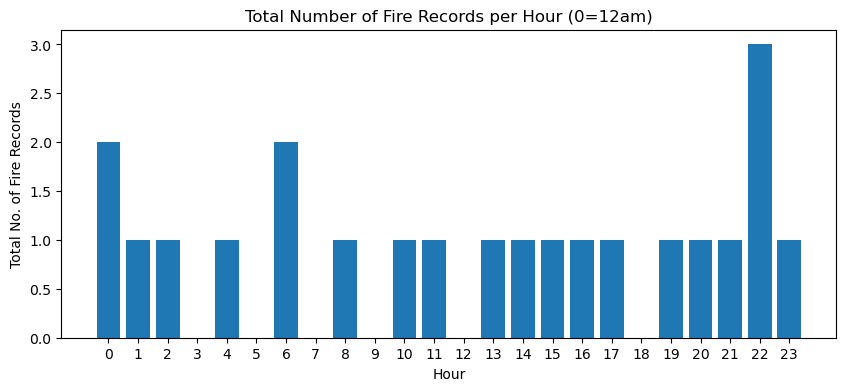

In [202]:
# Figure Size
fig = plt.figure(figsize =(10, 4))
plt.bar(range(24), count_fires)
plt.xticks(range(24))
plt.xlabel("Hour")
plt.ylabel("Total No. of Fire Records")
plt.title("Total Number of Fire Records per Hour (0=12am)")
plt.show()

In a map visualise fire locations as markers. Use a ‘blue’ marker if the cause of the fire was ‘natural’. Otherwise, use a ‘red’ marker. Display detailed information such as air temperature, surface temperature, relative humidity,  and confidence with the marker tooltip. See the example below. You can use Folium for map visualisation.

### Map

In [ ]:
# Make sure to install these packages before running (Uncomment to install):
!pip install folium

In [235]:
import folium

In [236]:
def val_or_null(row, item):
    try:
        return row[item]
    except:
        return None

In [237]:
# Create map
fomap = folium.Map(location=[-36.3, 145.1], zoom_start=7)

# Connect to mongodb
client = MongoClient(ip_address, 27017)
db = client["A3_db"]
collection = db["ClimateHotspot"]

# Looping through all the data
for row in collection.find():
    # Get attributes of climate data
    air_temperature = val_or_null(row,"air_temperature")
    relative_humidity = val_or_null(row,"relative_humidity")
    GHI = val_or_null(row,"GHI")
    max_wind_speed = val_or_null(row,"max_wind_speed")
    windspeed_knots = val_or_null(row,"windspeed_knots")
    percipitation = str(val_or_null(row,"precipitation")) + str(val_or_null(row,"precipitation_flag"))
    # Some document doesn't have any hotspot_data (fire record), so we should be careful
    try:
        hotspot_data = row['hotspot_data']
    except:
        hotspot_data = []
    for hotspot in hotspot_data:
        try:
            # Get attributes of fire data
            latitude = float(hotspot['hotspot_latitude'])
            longitude = float(hotspot['hotspot_longitude'])
            surface_temperature = val_or_null(hotspot,"surface_temperature")
            confidence = val_or_null(hotspot,"confidence")
            hotspot_datetime = val_or_null(hotspot,"datetime")
            try:
                hotspot_datetime = datetime.strptime(hotspot_datetime, "%Y-%m-%dT%H:%M:%S.%fZ")
            except:
                pass
            cause = val_or_null(hotspot,"cause")
            
            # Definfe the informations will be shown
            popup=f"latitude: {latitude:.2f}, \
                    longitdue: {longitude:.2f}, \
                    datetime: {hotspot_datetime}, \
                    cause: {cause}, \
                    air_temp: {air_temperature}, \
                    surface_temp: {surface_temperature}, \
                    confidence: {confidence}, \
                    relative_humidity: {relative_humidity}, \
                    GHI: {GHI}, \
                    max_windspeed: {max_wind_speed}, \
                    windspeed_knots: {windspeed_knots}, \
                    precipitation: {percipitation} \
                    "
            # If cause is natural, marker color is blue, otherwise red
            if cause == "natural":
                color = "blue"
            else:
                color = "red"
                
            # Define marker and add to map
            marker = folium.Marker(location=[latitude, longitude], popup=popup, icon=folium.Icon(color=color))
            marker.add_to(fomap)
        except:
            print("ERROR")

In [238]:
# Show map
# Do the following beforehand:File -> Trust Notebook
fomap